In [1]:
# Install gdown
!pip install gdown

# Download the file from Google Drive
file_id = '1EqgSRkjtUMnUEGAOAX6onKWeO0Ax51G6'
!gdown --id {file_id} --output dataset.zip

# Unzip the downloaded file (if it is a zip file)
!unzip dataset.zip -d ./dataset


[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


^C


'unzip' is not recognized as an internal or external command,
operable program or batch file.


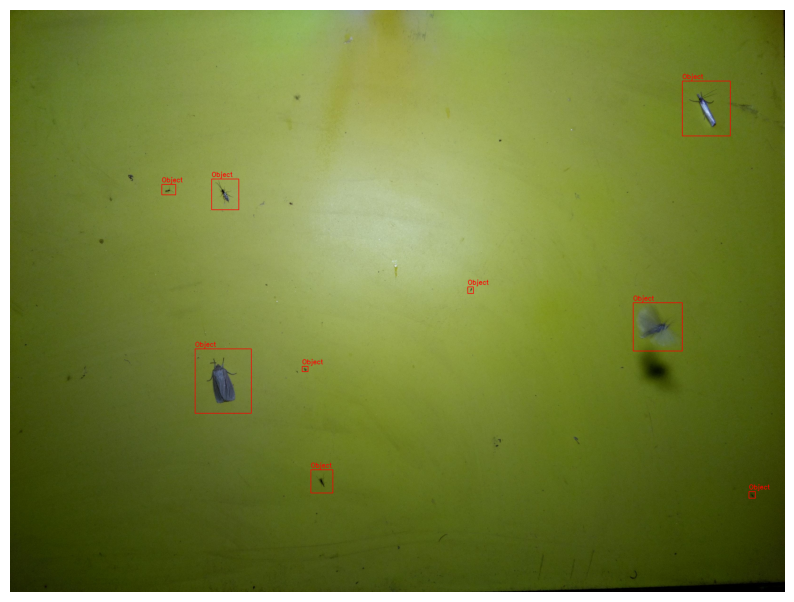

{
    "annotations": [
        {
            "labels": [
                {
                    "probability": 1.0,
                    "name": "Object",
                    "color": "#e1e7d9ff"
                }
            ],
            "shape": {
                "x": 853,
                "y": 718,
                "width": 115,
                "height": 130,
                "type": "RECTANGLE"
            }
        },
        {
            "labels": [
                {
                    "probability": 1.0,
                    "name": "Object",
                    "color": "#e1e7d9ff"
                }
            ],
            "shape": {
                "x": 2845,
                "y": 304,
                "width": 203,
                "height": 232,
                "type": "RECTANGLE"
            }
        },
        {
            "labels": [
                {
                    "probability": 1.0,
                    "name": "Object",
                    "color": "#e1e7d9ff"
   

In [1]:
import os
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence

# Paths to the image and annotation directories
image_dir = './dataset/public/images'
annotation_dir = './dataset/public/annotations'

# Function to plot image with bounding boxes
def plot_image_with_annotations(img_path, annotation_path, prediction=None):
    # Load the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Load the annotations
    with open(annotation_path) as f:
        data = json.load(f)
    
    # Draw bounding boxes and labels from ground truth
    for ann in data['annotations']:
        shape = ann['shape']
        x_min = shape['x']
        y_min = shape['y']
        x_max = x_min + shape['width']
        y_max = y_min + shape['height']
        label = ann['labels'][0]['name']  # Assuming only one label per annotation
        
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(img, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    
    # Draw bounding boxes from prediction if available
    if prediction is not None:
        h, w, _ = img.shape
        x_min_pred = int(prediction[0] * w)
        y_min_pred = int(prediction[1] * h)
        x_max_pred = int(prediction[2] * w)
        y_max_pred = int(prediction[3] * h)
        
        cv2.rectangle(img, (x_min_pred, y_min_pred), (x_max_pred, y_max_pred), (0, 255, 0), 2)
        cv2.putText(img, "Prediction", (x_min_pred, y_min_pred - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
# List all images and annotations
image_files = os.listdir(image_dir)
annotation_files = os.listdir(annotation_dir)

# Example: Visualize the first image and its annotations
sample = image_files[3]
sample_image = os.path.join(image_dir, sample)
sample_annotation = os.path.join(annotation_dir, sample.replace('.jpg', '.json'))

plot_image_with_annotations(sample_image, sample_annotation)


with open(sample_annotation) as f:
        data = json.load(f)
        data = json.dumps(data, indent=4)
print(data)

In [2]:
from sklearn.model_selection import train_test_split

# List of all image files
all_images = os.listdir(image_dir)

# Split into train, validation, and test sets
train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
train_images, val_images = train_test_split(train_images, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Test set: {len(test_images)} images")


Training set: 1941 images
Validation set: 648 images
Test set: 648 images


In [3]:
import os
import json
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, image_files, image_dir, annotation_dir, batch_size=32, image_size=(224, 224)):
        self.image_files = image_files
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.indexes = np.arange(len(self.image_files))

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_files = [self.image_files[i] for i in batch_indexes]
        return self.__data_generation(batch_image_files)

    def __data_generation(self, batch_image_files):
        X = []
        y = []

        for image_file in batch_image_files:
            image_path = os.path.join(self.image_dir, image_file)
            annotation_path = os.path.join(self.annotation_dir, image_file.replace('.jpg', '.json'))

            # Load and preprocess image
            img = cv2.imread(image_path)
            img_resized = cv2.resize(img, self.image_size)
            X.append(img_resized)

            # Load and preprocess annotation
            with open(annotation_path, 'r') as f:
                annotation = json.load(f)

            if annotation['annotations']:
                bbox = annotation['annotations'][0]['shape']
                x_min = bbox['x']
                y_min = bbox['y']
                x_max = x_min + bbox['width']
                y_max = y_min + bbox['height']

                # Normalize bounding box coordinates
                h, w, _ = img.shape
                x_min /= w
                y_min /= h
                x_max /= w
                y_max /= h

                # Assuming "Object" is the only class, otherwise use proper label encoding
                y.append([x_min, y_min, x_max, y_max, 1.0])  # 1.0 for class probability
            else:
                # Handle the case where there are no annotations
                y.append([0, 0, 0, 0, 0])  # No object detected

        return np.array(X), np.array(y)


In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def build_model(input_shape):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False)
    x = base_model.output
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = Flatten()(x)
    outputs = Dense(5, activation='sigmoid')(x)  # 4 for bounding box, 1 for class probability

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create data generators
batch_size = 32
train_generator = DataGenerator(train_images, image_dir, annotation_dir, batch_size=batch_size, image_size=(224, 224))
val_generator = DataGenerator(val_images, image_dir, annotation_dir, batch_size=batch_size, image_size=(224, 224))

input_shape = (224, 224, 3)
model = build_model(input_shape)

# Define callbacks
checkpoint = ModelCheckpoint('detection_model_weights.weights.h5', save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Train the model
#model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[checkpoint, early_stopping])


In [5]:
test_generator = DataGenerator(test_images, image_dir, annotation_dir, batch_size=batch_size, image_size=(224, 224))
model.load_weights('model_weightsold.weights.h5')
test_loss, test_mae = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

21/21 [==============================] - 158s 7s/step - loss: 0.2611 - mae: 0.3923
Test Loss: 0.2611325681209564
Test MAE: 0.39232587814331055


In [6]:
model.load_weights('model_weights.weights.h5')
test_loss, test_mae = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

ValueError: Layer 'Conv1' expected 1 variables, but received 0 variables during loading. Expected: ['Conv1/kernel:0']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


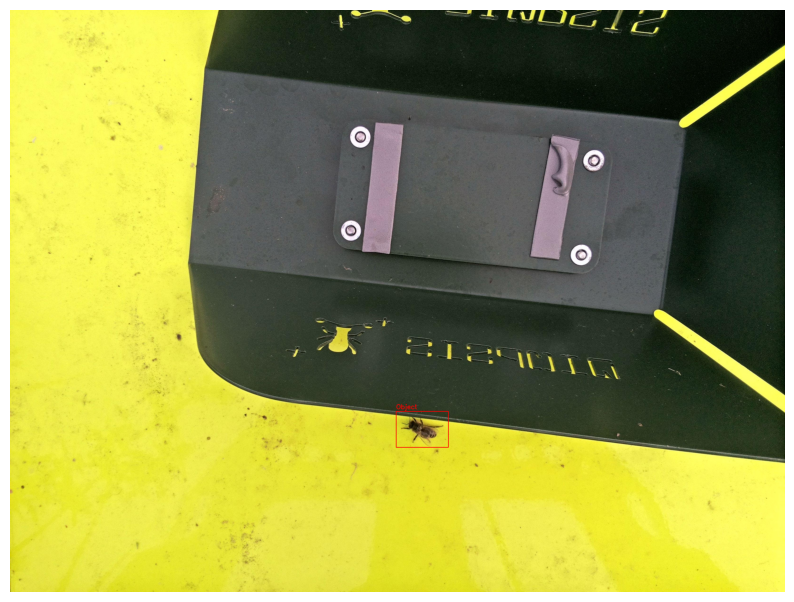

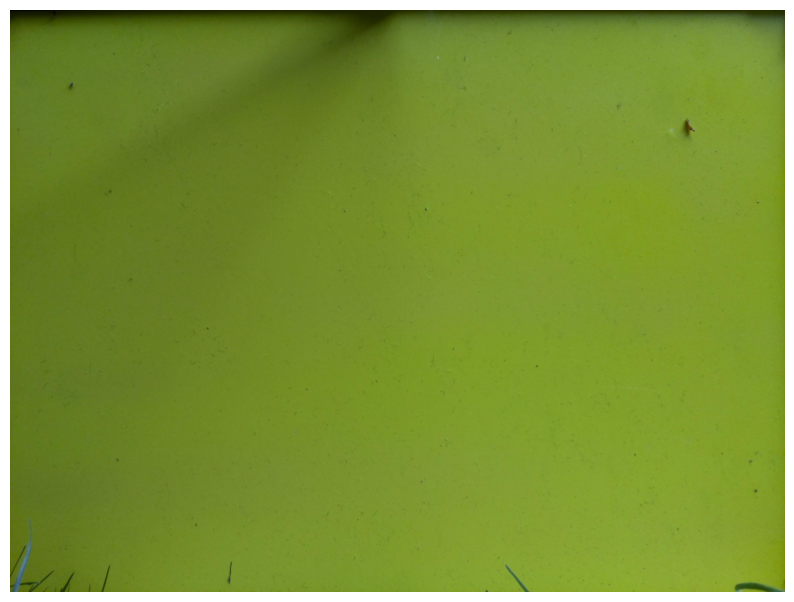

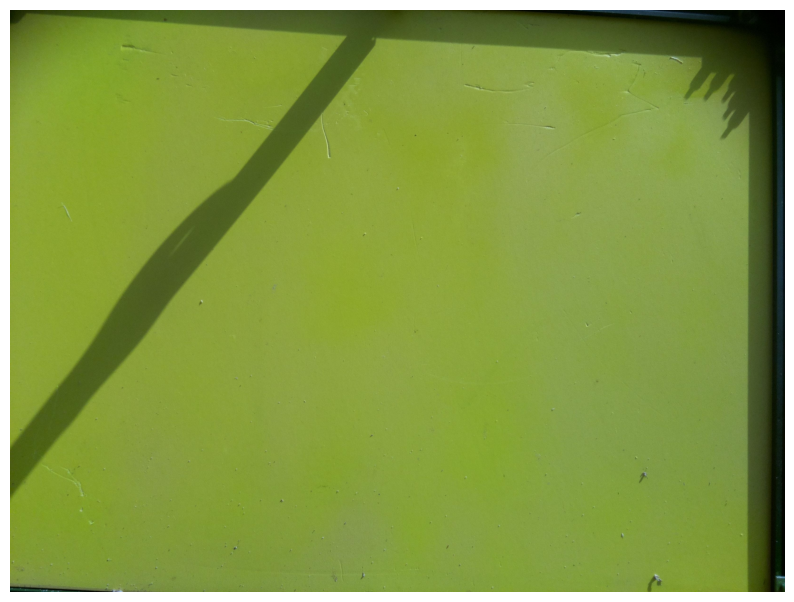

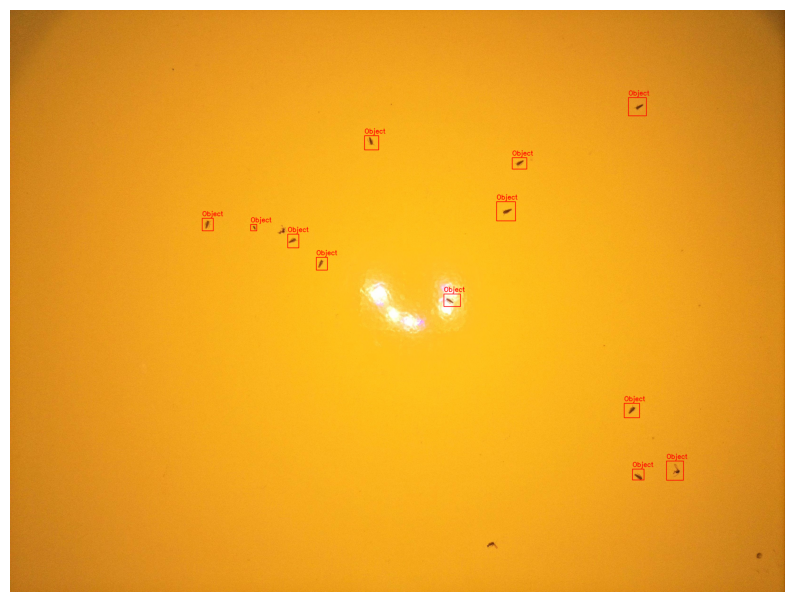

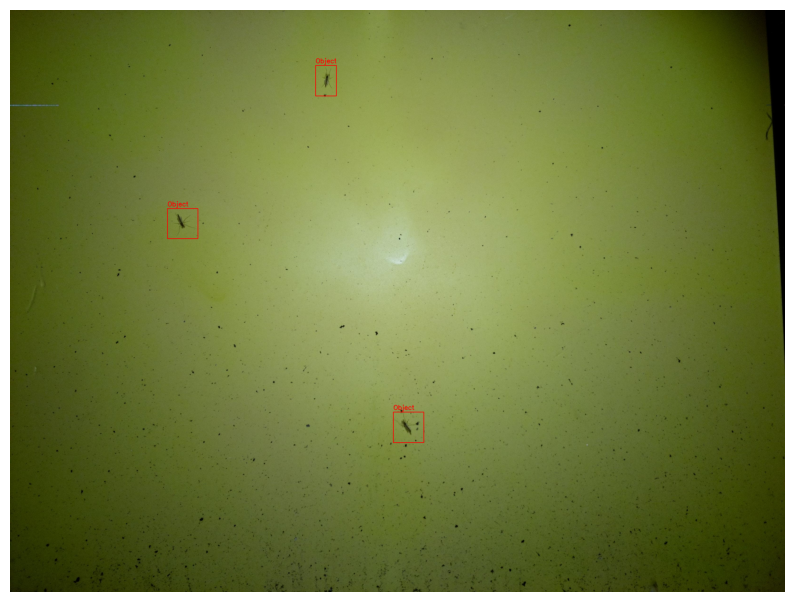

In [13]:
def visualize_predictions(model, test_generator, num_samples=5):
    total_samples_processed = 0
    
    for i in range(len(test_generator)):
        if total_samples_processed >= num_samples:
            break

        img_batch, _ = test_generator[i]
        predictions = model.predict(img_batch)

        for j in range(len(img_batch)):
            if total_samples_processed >= num_samples:
                break

            img = img_batch[j]
            prediction = predictions[j]

            # Denormalize the bounding box coordinates
            h, w, _ = img.shape
            x_min_pred = int(prediction[0] * w)
            y_min_pred = int(prediction[1] * h)
            x_max_pred = int(prediction[2] * w)
            y_max_pred = int(prediction[3] * h)

            # Load the original image path
            img_path = os.path.join(image_dir, test_generator.image_files[test_generator.indexes[i * test_generator.batch_size + j]])
            annotation_path = os.path.join(annotation_dir, test_generator.image_files[test_generator.indexes[i * test_generator.batch_size + j]].replace('.jpg', '.json'))

            # Plot the image with ground truth and predicted bounding boxes
            plot_image_with_annotations(img_path, annotation_path, prediction=[x_min_pred, y_min_pred, x_max_pred, y_max_pred])

            total_samples_processed += 1

# Visualize predictions on test data
visualize_predictions(model, test_generator, num_samples=5)


In [14]:
model.save_weights('detection_model_weights.weights.h5')

In [15]:
from IPython.display import FileLink
FileLink('detection_model_weights.weights.h5')

/kaggle/working/detection_model_weights.weights.h5

In [8]:
def predict(inputs):
    inputs = list(inputs)
    ids = [Path(input).stem for input in inputs]
    
    results = []
    for img_path in inputs:
        img = cv2.imread(str(img_path))
        img_resized = cv2.resize(img, (224, 224))
        img_resized = np.expand_dims(img_resized, axis=0)
        
        prediction = model.predict(img_resized)[0]
        
        x_min = int(prediction[0] * img.shape[1])
        y_min = int(prediction[1] * img.shape[0])
        x_max = int(prediction[2] * img.shape[1])
        y_max = int(prediction[3] * img.shape[0])
        probability = prediction[4]
        
        if probability > 0.5:  # Assuming 0.5 as threshold for detection
            result = {
                "annotations": [
                    {
                        "labels": [
                            {
                                "probability": probability,
                                "name": "Object",
                            }
                        ],
                        "shape": {
                            "x": x_min,
                            "y": y_min,
                            "width": x_max - x_min,
                            "height": y_max - y_min,
                        }
                    }
                ]
            }
        else:
            result = {"annotations": []}  # No objects detected
        
        results.append(result)
    
    result = [{"id": cid, "result": cresult} for cid, cresult in zip(ids, results)]
    
    destination_dir = Path("/output/")
    destination_dir.mkdir(parents=True, exist_ok=True)
    for res in result:
        filename = destination_dir / f"{res['id']}.json"
        with open(str(filename), "w") as file:
            json.dump(res['result'], file)
